In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from pathlib import Path

# Load the concatenated table
ROOT = Path("/Users/hugo/MOLECL/Molecl_data_H")
all_df = pd.read_csv(ROOT / "all_events_labeled.csv")


In [27]:
features = [
    "average_blockage", "maximum_blockage","delta_mae_filtered_raw",
    "delta_mae_fit_raw"#, "kurtosis_excess_raw_resid"
    #"duration_s", "auc_abs", "delta_area_filtered_raw", "skewness_raw_resid", "delta_area_fit_raw"
]

X = all_df[features].copy()
y = all_df["sample_label"].copy()

# handle inf/nan
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train class counts:\n", y_train.value_counts())
print("\nTest class counts:\n", y_test.value_counts())


Train class counts:
 sample_label
sample1    3660
sample2    2700
sample3     864
Name: count, dtype: int64

Test class counts:
 sample_label
sample1    916
sample2    675
sample3    216
Name: count, dtype: int64


F1-macro: 0.7544669826390257

Classification report:
               precision    recall  f1-score   support

     sample1       0.82      0.84      0.83       916
     sample2       0.70      0.75      0.72       675
     sample3       0.93      0.57      0.71       216

    accuracy                           0.78      1807
   macro avg       0.81      0.72      0.75      1807
weighted avg       0.79      0.78      0.78      1807



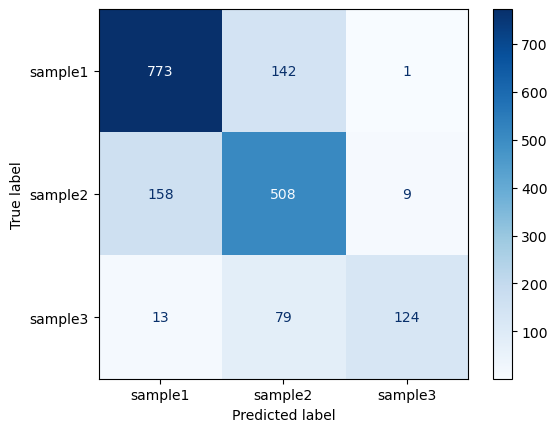

In [29]:
clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
)

clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Metrics
print("F1-macro:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.show()


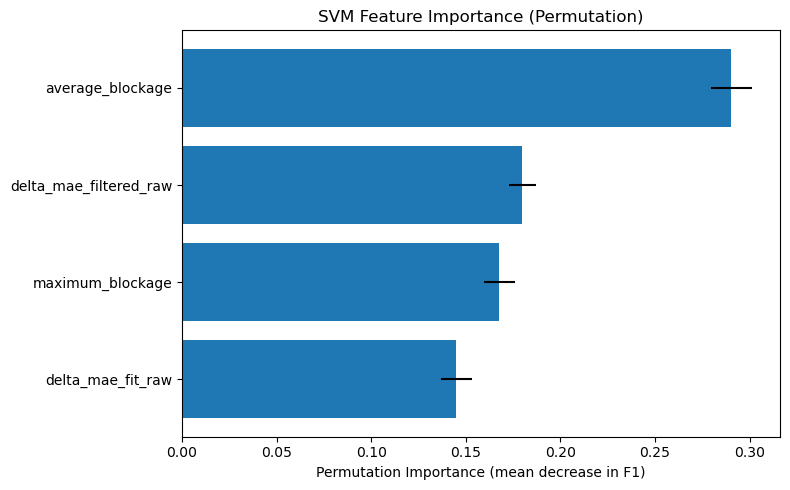

,feature,importance_mean,importance_std
0,average_blockage,0.290426,0.010611
2,delta_mae_filtered_raw,0.179930,0.007352
1,maximum_blockage,0.167792,0.008236
3,delta_mae_fit_raw,0.145065,0.008353


In [30]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=15, random_state=42, n_jobs=-1
)

importances = pd.DataFrame({
    "feature": features,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.barh(importances["feature"], importances["importance_mean"], xerr=importances["importance_std"])
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance (mean decrease in F1)")
plt.title("SVM Feature Importance (Permutation)")
plt.tight_layout()
plt.show()

importances